# 1. Import the libraries 

In [1]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

D:\Softwares\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 2. Load the dataset and add headers

In [2]:
# Import the dataset and give the column names
columns=['userId', 'productId', 'ratings','timestamp']
df1=pd.read_csv('ratings_Electronics.csv',names=columns)
df2=pd.read_csv('ratings_Clothing_Shoes_and_Jewelry.csv',names=columns)
df3=pd.read_csv('ratings_Sports_and_Outdoors.csv',names=columns)
df4=pd.read_csv('ratings_Video_Games.csv',names=columns)


In [4]:
df1 = df1.drop(df1.index[50000:])
df2 = df2.drop(df2.index[50000:])
df3 = df3.drop(df3.index[50000:])
df4 = df4.drop(df4.index[50000:])



In [5]:
frames = [df1, df2, df3, df4]
electronics_df = pd.concat(frames)
electronics_df.shape

(200000, 4)

In [6]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


#### Dropping the timestamp column

In [7]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [8]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 49999
Data columns (total 3 columns):
userId       200000 non-null object
productId    200000 non-null object
ratings      200000 non-null float64
dtypes: float64(1), object(2)
memory usage: 6.1+ MB


In [9]:
#Check the number of rows and columns
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  200000
Number of columns:  3


In [10]:
#Check the datatypes
electronics_df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [11]:
#Taking subset of the dataset
electronics_df1=electronics_df.iloc[:150000,0:]

* Since the data is very big. Consider electronics_df1 named dataframe with  first 50000 rows and all columns from 0 of dataset.

In [12]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 49999
Data columns (total 3 columns):
userId       150000 non-null object
productId    150000 non-null object
ratings      150000 non-null float64
dtypes: float64(1), object(2)
memory usage: 4.6+ MB


In [13]:
#Summary statistics of rating variable
electronics_df1['ratings'].describe().transpose()

count    150000.000000
mean          4.160627
std           1.271989
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: ratings, dtype: float64

In [14]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df1.ratings.min()))
print('Maximum rating is: %d' %(electronics_df1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


* Rating are on the scale 1 to 5.

# Handling Missing values

In [15]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      0
dtype: int64


* There are no missing records in the dataset.

## Ratings

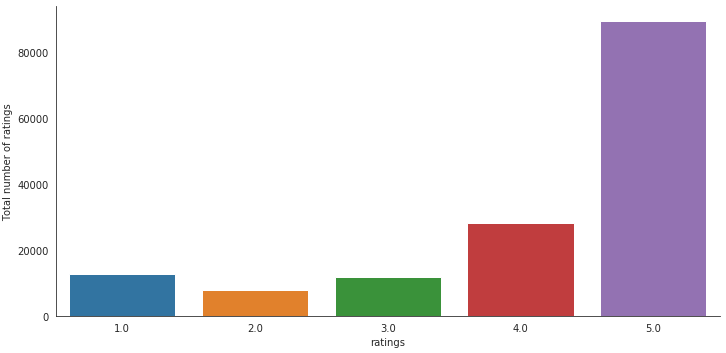

In [16]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=electronics_df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

* We can see that more number of users have given the rating of 5.

## Users and products

In [17]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df1['productId'].nunique())

Number of unique users in Raw data =  140459
Number of unique product in Raw data =  9516


# 3. Taking the subset of dataset to make it less sparse/ denser.

In [18]:
#Check the top 10 users based on ratings
most_rated=electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
A231WM2Z2JL0U3    40
AY8Q1X7G96HV5     31
A1RPTVW5VEOSI     21
A1MJMYLRTZ76ZX    21
ALUNVOQRXOZIA     20
A243HY69GIAHFI    19
A1NVD0TKNS1GT5    19
AF3EVH5OFWIQN     18
A1ISUNUWG0K02V    17
AVOGV98AYOFG2     16
dtype: int64


In [19]:
counts=electronics_df1.userId.value_counts()
electronics_df1_final=electronics_df1[electronics_df1.userId.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['userId'].nunique())

Number of users who have rated 25 or more items = 329
Number of unique users in the final data =  17
Number of unique products in the final data =  17


* electronics_df1_final has the users who have rated 25 or more items.

## ratings analysis in final dataset

In [20]:
#constructing the pivot table
final_ratings_matrix = electronics_df1_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,1300310065,1300827300,1300827327,130082753X,1300966920,1300966947,1300966955,130097673X,1304046176,1304085635,...,B0000A0AIN,B0000ADX7D,B0000AS4XP,B0000AV1T0,B0000AVDAS,B0000AVE3Q,B0000AVE3R,B0000AWM30,B0000AY9W6,B0000DYKET
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* It shows that it is a sparse matrix. So, many cells are filled with 0 values.

In [21]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (17, 266)


* We can see that there are 7 products and 236 users.

In [22]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  329
possible_num_of_ratings =  4522
density: 7.28%


* The density value of the matrix also shows that it is a sparse matrix.

# 4. Splitting the data

In [23]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
41650,A231WM2Z2JL0U3,B00004SD9Q,5.0
13536,A1NVD0TKNS1GT5,B00000J579,5.0
29472,A3OXHLG6DIBRW8,B00009363P,4.0
12356,A1MJMYLRTZ76ZX,B00000J434,4.0
16480,A3IBOQ8R44YG9L,B00000JHWX,5.0


In [24]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (230, 3)
Shape of testing data:  (99, 3)


# 5. Building Popularity Recommder model

In [25]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,1300310065,1
1,1300827300,1
2,1300827327,1
3,130082753X,2
4,1300966920,1
5,1300966947,2
6,1300966955,2
7,130097673X,2
8,1304046176,1
9,1304085635,2


In [26]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,rank
135,B00004SB92,6,1.0
114,B00004RC2D,4,2.0
86,B00002SWHH,3,3.0
115,B00004RC2E,3,4.0
137,B00004SC3Y,3,5.0


In [27]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [28]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 10

     userId   productId  score  rank
135      10  B00004SB92      6   1.0
114      10  B00004RC2D      4   2.0
86       10  B00002SWHH      3   3.0
115      10  B00004RC2E      3   4.0
137      10  B00004SC3Y      3   5.0


The list of recommendations for the userId: 100

     userId   productId  score  rank
135     100  B00004SB92      6   1.0
114     100  B00004RC2D      4   2.0
86      100  B00002SWHH      3   3.0
115     100  B00004RC2E      3   4.0
137     100  B00004SC3Y      3   5.0


The list of recommendations for the userId: 150

     userId   productId  score  rank
135     150  B00004SB92      6   1.0
114     150  B00004RC2D      4   2.0
86      150  B00002SWHH      3   3.0
115     150  B00004RC2E      3   4.0
137     150  B00004SC3Y      3   5.0




* Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

# 6. Building Collaborative Filtering recommender model.

In [29]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,41650,A231WM2Z2JL0U3,B00004SD9Q,5.0
1,13536,A1NVD0TKNS1GT5,B00000J579,5.0
2,29472,A3OXHLG6DIBRW8,B00009363P,4.0
3,12356,A1MJMYLRTZ76ZX,B00000J434,4.0
4,16480,A3IBOQ8R44YG9L,B00000JHWX,5.0


## User Based Collaborative Filtering model

In [30]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = electronics_df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,1300310065,1300827300,1300827327,130082753X,1300966920,1300966947,1300966955,130097673X,1304046176,1304085635,...,B0000A0AIN,B0000ADX7D,B0000AS4XP,B0000AV1T0,B0000AVDAS,B0000AVE3Q,B0000AVE3R,B0000AWM30,B0000AY9W6,B0000DYKET
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (17, 266)


In [32]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,1300310065,1300827300,1300827327,130082753X,1300966920,1300966947,1300966955,130097673X,1304046176,1304085635,...,B0000ADX7D,B0000AS4XP,B0000AV1T0,B0000AVDAS,B0000AVE3Q,B0000AVE3R,B0000AWM30,B0000AY9W6,B0000DYKET,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A1RPTVW5VEOSI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,3
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [33]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,1300310065,1300827300,1300827327,130082753X,1300966920,1300966947,1300966955,130097673X,1304046176,1304085635,...,B0000A0AIN,B0000ADX7D,B0000AS4XP,B0000AV1T0,B0000AVDAS,B0000AVE3Q,B0000AVE3R,B0000AWM30,B0000AY9W6,B0000DYKET
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* As this is a sparse matrix we will use SVD.

### Singular Value Decomposition

In [34]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

In [35]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 8.93762238e-02 -7.96130435e-02  5.64380948e-02  3.61989634e-01
   1.26744356e-01  6.50851850e-02 -1.93503188e-01  1.32960114e-01
   1.43757199e-16 -1.26008480e-01]
 [ 1.97593237e-02  1.09041751e-01  2.25061962e-02 -2.64194309e-02
   1.62705305e-01  2.78565344e-01  8.10936449e-01  4.43373906e-01
  -3.26242840e-18 -1.21370726e-01]
 [-5.02498847e-02  2.28179191e-01 -4.40660893e-03 -1.03307421e-01
  -4.93372015e-01  3.01843042e-01 -7.25069669e-02 -2.30297056e-02
  -9.76719610e-17 -1.11921596e-01]
 [ 4.02968139e-02 -6.95286282e-02 -4.24692361e-02 -5.82925290e-01
   3.73239102e-01  5.38055596e-01 -3.78594866e-01  1.47140623e-01
   1.29710773e-16 -1.26877075e-01]
 [-7.75023684e-03  5.98738470e-02 -7.56835844e-02 -9.57222306e-02
  -6.94333194e-03 -2.39302363e-01  5.74045248e-02 -2.27172586e-01
  -8.60718455e-17 -9.23345270e-01]
 [ 6.58616686e-02 -6.42315703e-01  5.83035055e-02  4.48855513e-01
  -4.18146386e-02  3.61379214e-01 -4.37103668e-02  8.64117553e-03
   1.3053

In [36]:
print('Sigma: \n',sigma)

Sigma: 
 [17.25026832 18.09032993 18.86984817 19.31777542 19.60395535 20.76102421
 21.58630552 23.5340795  27.854833   30.07973459]


* As sigma is not a diagonal matrix we have to convert it into diagonal matrix.

In [37]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[17.25026832  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         18.09032993  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         18.86984817  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         19.31777542  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         19.60395535  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         20.76102421
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  21.58630552  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         23.5340795   0.          0.        ]
 [ 0.          0.          0.        

In [38]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-5.95409549e-17  1.48354888e-17 -4.47054661e-17 ... -2.08320751e-01
  -2.60400939e-01  5.72725111e-03]
 [ 1.26017840e-18 -2.14287700e-17 -2.01685916e-17 ...  1.59264685e-03
   1.99080856e-03  3.01381321e-02]
 [ 5.87634570e-17  2.95158659e-17  8.82793229e-17 ...  2.20549736e-03
   2.75687171e-03  5.96353399e-03]
 ...
 [-7.33624770e-17 -1.86215268e-16 -2.59577745e-16 ...  1.27181432e-04
   1.58976791e-04  9.41982682e-02]
 [ 1.31370928e-01  1.22321994e-01  2.53692921e-01 ... -5.43968605e-18
  -6.79960756e-18 -5.85612630e-19]
 [ 1.39545313e-18  6.12976922e-18  7.52522235e-18 ... -7.89872759e-04
  -9.87340949e-04 -2.01748332e-02]]


In [39]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,1300310065,1300827300,1300827327,130082753X,1300966920,1300966947,1300966955,130097673X,1304046176,1304085635,...,B0000A0AIN,B0000ADX7D,B0000AS4XP,B0000AV1T0,B0000AVDAS,B0000AVE3Q,B0000AVE3R,B0000AWM30,B0000AY9W6,B0000DYKET
0,4.102054e-16,-3.697367e-16,4.046864e-17,4.046864e-17,-3.697367e-16,4.046864e-17,4.046864e-17,4.046864e-17,4.046864e-17,4.046864e-17,...,-0.383211,0.056800,0.047276,-0.479014,-0.383211,-0.065683,-0.065683,-0.383211,-0.479014,-0.295650
1,-1.798791e-15,-5.340598e-16,-2.332851e-15,-2.332851e-15,-5.340598e-16,-2.332851e-15,-2.332851e-15,-2.332851e-15,-2.332851e-15,-2.332851e-15,...,-0.080047,-0.010775,0.066648,-0.100058,-0.080047,-0.040539,-0.040539,-0.080047,-0.100058,4.932430
2,-5.739712e-17,-8.305300e-16,-8.879271e-16,-8.879271e-16,-8.305300e-16,-8.879271e-16,-8.879271e-16,-8.879271e-16,-8.879271e-16,-8.879271e-16,...,0.621676,0.239518,-0.030881,0.777094,0.621676,0.295214,0.295214,0.621676,0.777094,-0.125491
3,1.880046e-15,-1.389128e-15,4.909175e-16,4.909175e-16,-1.389128e-15,4.909175e-16,4.909175e-16,4.909175e-16,4.909175e-16,4.909175e-16,...,-0.155942,-0.059279,-0.010581,-0.194927,-0.155942,4.789785,4.789785,-0.155942,-0.194927,-0.040539
4,-2.611720e-16,7.264600e-16,4.652880e-16,4.652880e-16,7.264600e-16,4.652880e-16,4.652880e-16,4.652880e-16,4.652880e-16,4.652880e-16,...,-0.034290,3.933275,0.073213,-0.042863,-0.034290,-0.074098,-0.074098,-0.034290,-0.042863,-0.013469


In [40]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [41]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)    


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B00004T1WZ                  0.0          0.762145
B00000J4ER                  0.0          0.762145
B00004T1WX                  0.0          0.762145
B00000JYLO                  0.0          0.762145
B00001P4XA                  0.0          0.746273


In [42]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B00000JDKT                  0.0          1.383995
B00000J3HB                  0.0          1.383995
B0000488VH                  0.0          1.383995
B00000JX2V                  0.0          1.383995
B00000J3H5                  0.0          1.383995


In [43]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B00003006E                  0.0          1.771562
B0000206CT                  0.0          1.313565
B00004SC3Y                  0.0          1.303560
B00001ZWRV                  0.0          1.214857
B00001ZT58                  0.0          1.214857


* Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

# 7. Evaluation of Collabrative recommendation model 

In [44]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,1300310065,1300827300,1300827327,130082753X,1300966920,1300966947,1300966955,130097673X,1304046176,1304085635,...,B0000A0AIN,B0000ADX7D,B0000AS4XP,B0000AV1T0,B0000AVDAS,B0000AVE3Q,B0000AVE3R,B0000AWM30,B0000AY9W6,B0000DYKET
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
1300310065    0.294118
1300827300    0.294118
1300827327    0.588235
130082753X    0.588235
1300966920    0.294118
dtype: float64

In [46]:
# Predicted ratings 
preds_df.head()

productId,1300310065,1300827300,1300827327,130082753X,1300966920,1300966947,1300966955,130097673X,1304046176,1304085635,...,B0000A0AIN,B0000ADX7D,B0000AS4XP,B0000AV1T0,B0000AVDAS,B0000AVE3Q,B0000AVE3R,B0000AWM30,B0000AY9W6,B0000DYKET
0,4.102054e-16,-3.697367e-16,4.046864e-17,4.046864e-17,-3.697367e-16,4.046864e-17,4.046864e-17,4.046864e-17,4.046864e-17,4.046864e-17,...,-0.383211,0.056800,0.047276,-0.479014,-0.383211,-0.065683,-0.065683,-0.383211,-0.479014,-0.295650
1,-1.798791e-15,-5.340598e-16,-2.332851e-15,-2.332851e-15,-5.340598e-16,-2.332851e-15,-2.332851e-15,-2.332851e-15,-2.332851e-15,-2.332851e-15,...,-0.080047,-0.010775,0.066648,-0.100058,-0.080047,-0.040539,-0.040539,-0.080047,-0.100058,4.932430
2,-5.739712e-17,-8.305300e-16,-8.879271e-16,-8.879271e-16,-8.305300e-16,-8.879271e-16,-8.879271e-16,-8.879271e-16,-8.879271e-16,-8.879271e-16,...,0.621676,0.239518,-0.030881,0.777094,0.621676,0.295214,0.295214,0.621676,0.777094,-0.125491
3,1.880046e-15,-1.389128e-15,4.909175e-16,4.909175e-16,-1.389128e-15,4.909175e-16,4.909175e-16,4.909175e-16,4.909175e-16,4.909175e-16,...,-0.155942,-0.059279,-0.010581,-0.194927,-0.155942,4.789785,4.789785,-0.155942,-0.194927,-0.040539
4,-2.611720e-16,7.264600e-16,4.652880e-16,4.652880e-16,7.264600e-16,4.652880e-16,4.652880e-16,4.652880e-16,4.652880e-16,4.652880e-16,...,-0.034290,3.933275,0.073213,-0.042863,-0.034290,-0.074098,-0.074098,-0.034290,-0.042863,-0.013469


In [47]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
1300310065    0.304221
1300827300    0.283266
1300827327    0.587488
130082753X    0.587488
1300966920    0.283266
dtype: float64

In [48]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(266, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
1300310065,0.294118,0.304221,0
1300827300,0.294118,0.283266,1
1300827327,0.588235,0.587488,2
130082753X,0.588235,0.587488,3
1300966920,0.294118,0.283266,4


In [49]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.08008 



# 8. Getting top - K ( K = 5) recommendations. 

In [50]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B00004RC2E                  0.0          0.837357
B00000JHVP                  0.0          0.739397
B000021YUO                  0.0          0.734769
B00004RIUJ                  0.0          0.724074
B00004RC2G                  0.0          0.657002


# Summarising insights.

* The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

* Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.